# Loan Prediction - 03 - Training and validation of first models

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
plt.style.use('seaborn')


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import calibration_curve

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix,recall_score, classification_report, auc, roc_curve

In [2]:
df_import = pd.read_csv('dataset/train_loan_preprocessed.csv')
df_import.drop(columns='Unnamed: 0',inplace = True)
df_import.head(10)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
1,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
2,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
3,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1
4,1,1,2,0,1,5417,4196.0,267.0,360.0,1.0,2,1
5,1,1,0,1,0,2333,1516.0,95.0,360.0,1.0,2,1
6,1,1,3,0,0,3036,2504.0,158.0,360.0,0.0,1,0
7,1,1,2,0,0,4006,1526.0,168.0,360.0,1.0,2,1
8,1,1,1,0,0,12841,10968.0,349.0,360.0,1.0,1,0
9,1,1,2,0,0,3200,700.0,70.0,360.0,1.0,2,1


In [3]:
columns_x = df_import.columns[:-1]
column_y = ['Loan_Status']

X_train, X_validation, y_train, y_validation = train_test_split(
    df_import[columns_x], df_import[column_y],  test_size=0.20, random_state=42)

In [4]:
scaler = MinMaxScaler()
scaler.fit(df_import[columns_x])

X_train_norm = pd.DataFrame(data=scaler.transform(X_train),columns=X_train.columns)
X_validation_norm = pd.DataFrame(data=scaler.transform(X_validation),columns=X_train.columns)

In [5]:
X_train_norm.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
count,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000
mean,0.823113,0.650943,0.249214,0.221698,0.136792,0.064581,0.037308,0.225717,0.687978,0.832547,0.497642
std,0.382024,0.477235,0.338416,0.415880,0.344034,0.072559,0.067158,0.134044,0.148552,0.373821,0.388966
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.034326,0.000000,0.153976,0.729730,1.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.046024,0.024744,0.196277,0.729730,1.000000,0.500000
75%,1.000000,1.000000,0.333333,0.000000,0.000000,0.070077,0.054222,0.263959,0.729730,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
X_validation_norm.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,0.792453,0.603774,0.279874,0.169811,0.094340,0.063555,0.048593,0.246081,0.698368,0.830189,0.551887
std,0.407477,0.491436,0.338490,0.377251,0.293689,0.081231,0.095400,0.145520,0.123326,0.377251,0.395987
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000742,0.000000,0.069374,0.108108,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.032260,0.000000,0.162437,0.729730,1.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.041002,0.036984,0.208968,0.729730,1.000000,0.500000
75%,1.000000,1.000000,0.666667,0.000000,0.000000,0.069397,0.058002,0.297800,0.729730,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.781534,0.812082,1.000000,1.000000,1.000000,1.000000


In [7]:
# lr = LogisticRegression()
# gnb = GaussianNB()
# svc = LinearSVC(C=1.0)
# rfc = RandomForestClassifier()

# classifiers = [(lr,'Logistic Regression'),(gnb,'Gaussian Naive Bayes'),(svc,'Support Vector Machine'),(rfc,'Random Forest')]
# for classifier,name in classifiers:
#     classifier.fit()

In [8]:
lr = LogisticRegression(random_state=0,solver='liblinear',verbose=1)
lr.fit(X_train_norm.values,y_train.values.ravel())

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

In [24]:
def predict(model,X,y):
    df_result = pd.DataFrame(columns=['TrueClass','Predicted'])
    df_result.Predicted = model.predict(X.values)
    df_result.TrueClass = y.values.ravel()
    return df_result

def plot_confusion_matrix(df,labels):
    conf_matrix = confusion_matrix(df.TrueClass, df.Predicted)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
    plt.title('Confusion matrix - Validation set',fontsize = 20)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')
    plt.show()
    return conf_matrix.ravel()
    
def show_performance(df,labels):
    c = classification_report(df.TrueClass, df.Predicted,target_names =labels)
    print(c)

In [25]:
df_result = predict(lr,X_validation_norm,y_validation)
df_result.head(10)

,TrueClass,Predicted
0,0,1
1,1,1
2,0,0
3,1,1
4,0,0
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


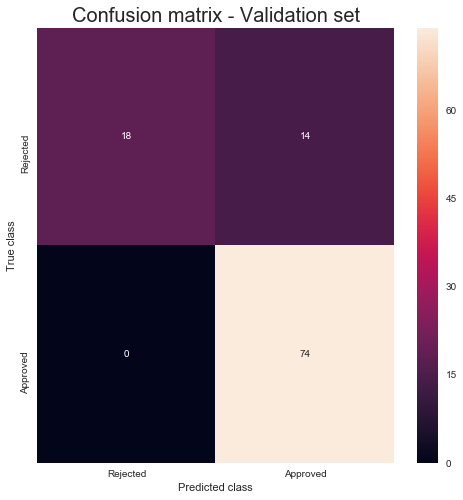

precision    recall  f1-score   support

    Rejected       1.00      0.56      0.72        32
    Approved       0.84      1.00      0.91        74

    accuracy                           0.87       106
   macro avg       0.92      0.78      0.82       106
weighted avg       0.89      0.87      0.86       106



In [26]:
labels = ['Rejected','Approved']
tn, fp, fn, tp = plot_confusion_matrix(df_result,labels)
show_performance(df_result,labels)

In [27]:
(tn, fp, fn, tp)

(18, 14, 0, 74)

In [28]:
pred_prob = lr.predict_proba(X_validation_norm.values)
pred_prob

array([[0.18972613, 0.81027387],
       [0.23937345, 0.76062655],
       [0.79899795, 0.20100205],
       [0.3164876 , 0.6835124 ],
       [0.78779002, 0.21220998],
       [0.14774978, 0.85225022],
       [0.29155499, 0.70844501],
       [0.10458928, 0.89541072],
       [0.26440711, 0.73559289],
       [0.15714057, 0.84285943],
       [0.15557418, 0.84442582],
       [0.88578238, 0.11421762],
       [0.23684003, 0.76315997],
       [0.22174522, 0.77825478],
       [0.29747804, 0.70252196],
       [0.24671441, 0.75328559],
       [0.23195671, 0.76804329],
       [0.80353674, 0.19646326],
       [0.20023817, 0.79976183],
       [0.15952411, 0.84047589],
       [0.27908114, 0.72091886],
       [0.22497493, 0.77502507],
       [0.26967807, 0.73032193],
       [0.18204841, 0.81795159],
       [0.16925777, 0.83074223],
       [0.82134349, 0.17865651],
       [0.23083444, 0.76916556],
       [0.17856107, 0.82143893],
       [0.23891135, 0.76108865],
       [0.14685191, 0.85314809],
       [0.

In [20]:
#TODO: Apply a RFE wrapper to select variables
#TODO: Execute a small grid search to try to tune the LogReg model
#TODO: Apply other models